INF6804<br>
Polytechnique Montréal<br>
TP3: Détection et suivi de multiples objets d'intérêt<br>

Auteurs:<br>
Marc-Olivier Bélanger - 1840713<br>
Pierre-Luc Chartier - 1805679

### Déclarations globales

In [19]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import scipy.optimize as sci
import torchvision.models as models
import torchvision.transforms as transforms
import urllib.request as request

In [14]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
    COCO_NAMES.append(label_name.strip().decode('UTF-8'))

IOU_THRESHOLD = 0.5
SCORE_THRESHOLD = 0.95

source_path = "/Users/mabelal/Downloads/TP3_data/frames"

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

### Détection des objets (Mask R-CNN)

In [24]:
def detect_objects(img):
    preprocess = transforms.Compose([transforms.ToTensor()])
    tensors = [preprocess(img)]
    
    predictions = model(tensors)
    boxes = []
    
    for p in predictions:
        for j, score in enumerate(p['scores']):
            if score >= SCORE_THRESHOLD:
                label = p['labels'][j]
                is_cup_or_person = (COCO_NAMES[label] == "cup") #or (COCO_NAMES[label] == "person")

                if is_cup_or_person:
                    boxes.append(p['boxes'][j].detach().numpy())
    return boxes

### Description des objets (Histogramme de couleurs)

In [25]:
def calc_color_hist(img, bbox):
    roi = (bbox[0], bbox[1], bbox[2], bbox[3])
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    cv2.rectangle(mask,(roi[0],roi[1]),(roi[2],roi[3]),255,-1,8,0);
    return cv2.calcHist([img],[0],mask,[64],[0,256])


def compare_color_hist(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

### Association des données (Algorithme hongrois)

In [26]:
def calc_cost_matrix(tracked_objects, prev_img, current_img, current_bboxes):
    cost_matrix = np.zeros((len(tracked_objects), len(current_bboxes)))
    for i in range(0,len(tracked_objects)):
        hist_prev = calc_color_hist(prev_img, tracked_objects[i].box())
        for j in range(0,len(current_bboxes)):
            hist_current = calc_color_hist(current_img, current_bboxes[j])
            cost_matrix[i,j] = compare_color_hist(hist_prev, hist_current)
    return cost_matrix


def associate_data(tracked_objects, prev_img, current_img, current_bboxes):
    cost_matrix = calc_cost_matrix(tracked_objects, prev_img, current_img, current_bboxes)
    
    row_ind, col_ind = sci.linear_sum_assignment(cost_matrix)
    for i in range(0, len(row_ind)):
        x_min, y_min, x_max, y_max = current_bboxes[col_ind[i]]
        tracked_objects[row_ind[i]].update(x_min, y_min, x_max, y_max, 0)
        
    return row_ind, col_ind

### Algorithme principal

In [27]:
class TrackedObject:
    def __init__(self, object_id, x_min, y_min, x_max, y_max):
        self.object_id = object_id
        self.count = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
    
    
    def update(self, x_min, y_min, x_max, y_max, count = None):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
        if count is not None:
            self.count = count
            
    
    def box(self):
        return self.x_min, self.y_min, self.x_max, self.y_max
    
    
    def __str__(self):
        ws = " "
        return ws.join([str(self.object_id+1), str(round(self.x_min)),
                        str(round(self.x_max)), str(round(self.y_min)), str(round(self.y_max))])

In [35]:
def algo(path_to_frames, tracked_objects, result_file):
    # some magic to get the frames in the right order
    frames = [name for name in os.listdir(path_to_frames) if os.path.isfile(os.path.join(path_to_frames, name))]
    frames = sorted(frames)
    frames = sorted(frames, key = lambda s : len(s))
    
    # initial frame
    prev_img = cv2.imread(os.path.join(path_to_frames, frames[0]), cv2.IMREAD_GRAYSCALE)
    f = open(result_file, "w+")
    for i in range(0, len(tracked_objects)):
        f.write("1 " + str(tracked_objects[i]) + "\n")
    
    # main loop
    for i in range(1, len(frames)):
        img = cv2.imread(os.path.join(path_to_frames, frames[i]), cv2.IMREAD_GRAYSCALE)
        boxes = detect_objects(img)
        associate_data(tracked_objects, prev_img, img, boxes)
        
        for j in range(0, len(tracked_objects)):
            f.write(str(i+1) + " " + str(tracked_objects[j]) + "\n")
        
        prev_img = img
        
        if (i % 5) == 0:
            print("Progress: " + frames[i])
    
    f.close()

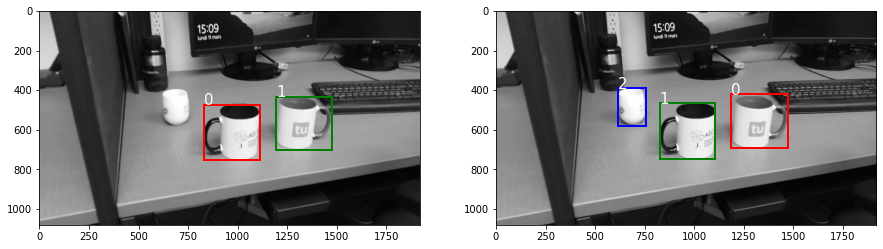

1 830 1112 474 755
2 1194 1479 433 700
[0 1]
[1 0]
1 826 1105 466 746
2 1185 1472 421 694


In [29]:
### Test association des données ###
img = cv2.imread(os.path.join(source_path, "frame1.jpg"), cv2.IMREAD_GRAYSCALE)

img2 = cv2.imread(os.path.join(source_path, "frame2.jpg"), cv2.IMREAD_GRAYSCALE)
b2 = detect_objects(img2)

fig, axarr = plt.subplots(1, 2, figsize=(15,15))
bboxcolor = 'rgbcmy'

axarr[0].imshow(img, cmap = plt.cm.gray)
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[0].add_patch(rect)
    axarr[0].text(b[0], b[1], i, color='white', fontsize=15)

axarr[1].imshow(img2, cmap = plt.cm.gray)
for i, b in enumerate(b2):
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    axarr[1].text(b[0], b[1], i, color='white', fontsize=15)
    
plt.show()

for to in tracked_objects.values():
    print(to)

row_ind, col_ind = associate_data(tracked_objects, img, img2, b2)
print(row_ind)
print(col_ind)

for to in tracked_objects.values():
    print(to)

############

### MOT17-11: Forward moving camera in a busy shopping mall

In [1]:
# calcul du MOTA en utilisant IoU > 50%

# will need to create tracked_objects or smtg
# call algo, print in results file, then use the file to compute MOTA

### MOT17-05: Street scene from a moving platform

In [31]:
# calcul du MOTA en utilisant IoU > 50%

### MOT17-13 : Filmed from a bus on a busy intersection

In [32]:
# calcul du MOTA en utilisant IoU > 50%

### Résultats sur les trames fournies

In [36]:
cup_1 = TrackedObject(0, 830, 474, 1112, 755)
cup_2 = TrackedObject(1, 1194, 433, 1479, 700)

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}

algo("/Users/mabelal/Downloads/TP3_data/frames", tracked_objects, "result_cups.txt")

Progress: frame6.jpg
Progress: frame11.jpg
Progress: frame16.jpg
Progress: frame21.jpg
Progress: frame26.jpg
Progress: frame31.jpg
Progress: frame36.jpg
Progress: frame41.jpg
Progress: frame46.jpg
Progress: frame51.jpg
Progress: frame56.jpg
Progress: frame61.jpg
Progress: frame66.jpg
Progress: frame71.jpg
Progress: frame76.jpg
Progress: frame81.jpg
Progress: frame86.jpg
Progress: frame91.jpg
Progress: frame96.jpg
Progress: frame101.jpg
Progress: frame106.jpg
Progress: frame111.jpg
Progress: frame116.jpg
Progress: frame121.jpg
Progress: frame126.jpg
Progress: frame131.jpg
Progress: frame136.jpg
Progress: frame141.jpg
Progress: frame146.jpg
Progress: frame151.jpg
Progress: frame156.jpg
Progress: frame161.jpg
Progress: frame166.jpg
Progress: frame171.jpg
Progress: frame176.jpg
Progress: frame181.jpg
Progress: frame186.jpg
Progress: frame191.jpg
Progress: frame196.jpg
Progress: frame201.jpg
Progress: frame206.jpg
Progress: frame211.jpg
Progress: frame216.jpg
Progress: frame221.jpg
Progress

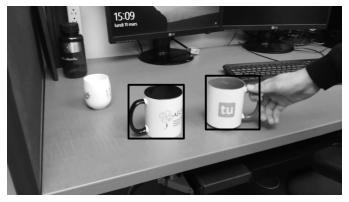

frame51.jpg
51 1 696 1013 450 757

51 2 1139 1447 398 705



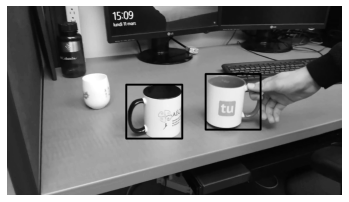

frame52.jpg
52 1 683 1004 449 757

52 2 1138 1453 388 706



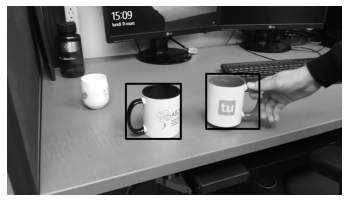

frame53.jpg
53 1 681 996 444 759

53 2 1141 1446 387 702



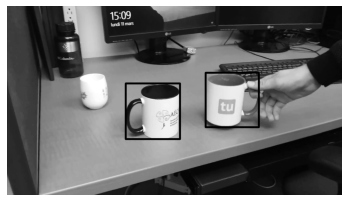

frame54.jpg
54 1 680 991 442 760

54 2 1138 1443 381 692



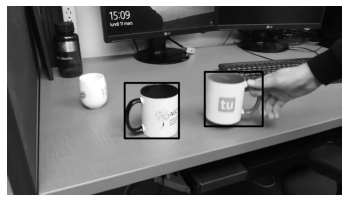

frame55.jpg
55 1 674 985 439 756

55 2 1133 1465 376 687



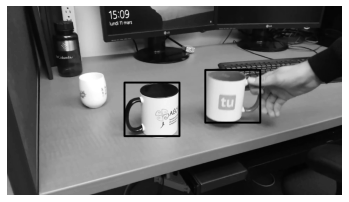

frame56.jpg
56 1 673 988 437 743

56 2 1136 1451 365 666



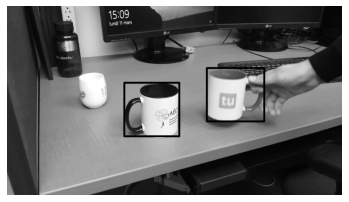

frame57.jpg
57 1 672 987 438 744

57 2 1145 1474 354 659



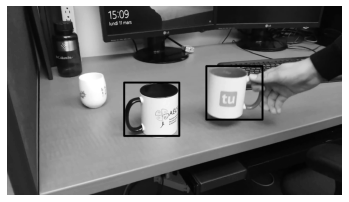

frame58.jpg
58 1 671 987 437 742

58 2 1142 1464 343 649



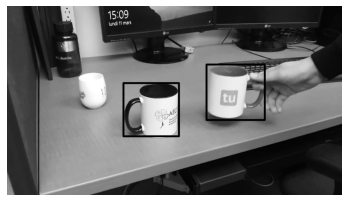

frame59.jpg
59 1 667 985 440 744

59 2 1143 1477 334 651



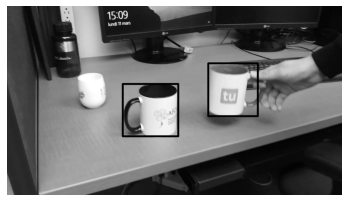

frame60.jpg
60 1 663 981 445 744

60 2 1153 1437 327 629



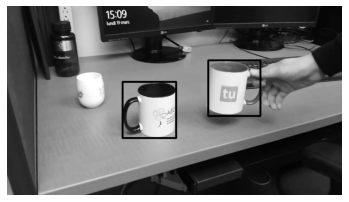

frame61.jpg
61 1 662 969 433 754

61 2 1153 1452 310 628



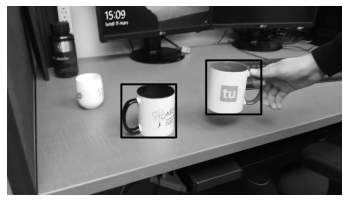

frame62.jpg
62 1 655 969 447 751

62 2 1141 1457 310 619



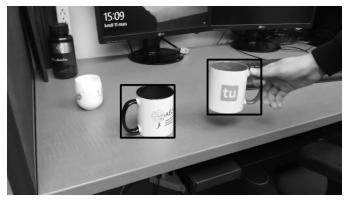

frame63.jpg
63 1 652 960 451 752

63 2 1149 1457 306 620



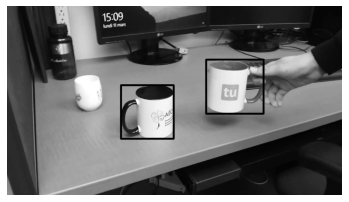

frame64.jpg
64 1 653 955 452 758

64 2 1141 1470 306 615



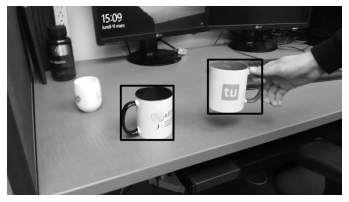

frame65.jpg
65 1 652 954 455 765

65 2 1151 1462 306 615



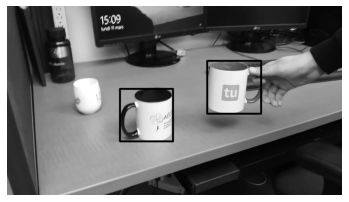

frame66.jpg
66 1 647 951 473 773

66 2 1147 1456 313 615



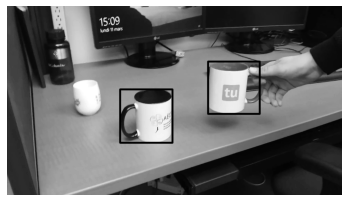

frame67.jpg
67 1 648 948 476 781

67 2 1152 1448 317 616



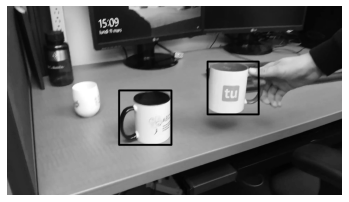

frame68.jpg
68 1 642 942 482 793

68 2 1149 1442 317 619



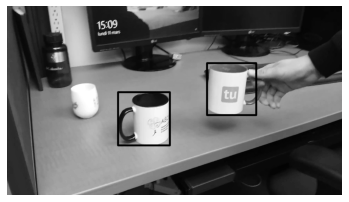

frame69.jpg
69 1 636 933 492 796

69 2 1146 1428 326 623



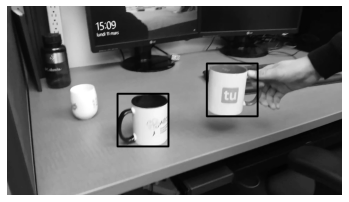

frame70.jpg
70 1 633 925 501 802

70 2 1145 1436 328 630



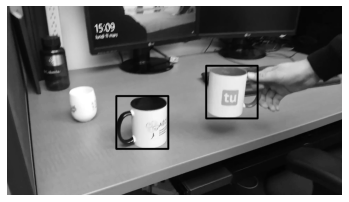

frame71.jpg
71 1 626 924 514 816

71 2 1141 1436 341 642



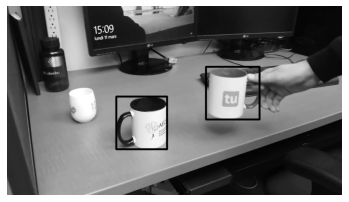

frame72.jpg
72 1 626 917 517 818

72 2 1140 1447 347 648



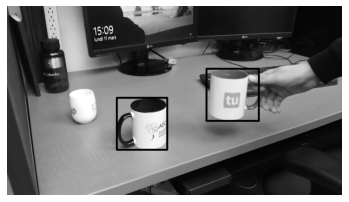

frame73.jpg
73 1 629 918 524 821

73 2 1143 1443 358 656



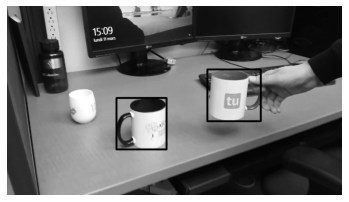

frame74.jpg
74 1 627 914 525 819

74 2 1148 1454 362 658



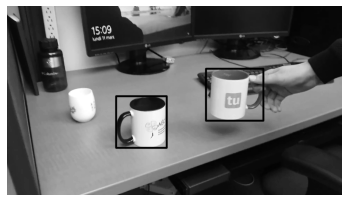

frame75.jpg
75 1 625 915 515 810

75 2 1140 1469 358 655



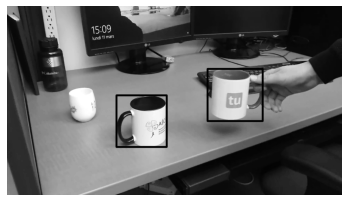

frame76.jpg
76 1 627 915 510 805

76 2 1149 1465 359 657



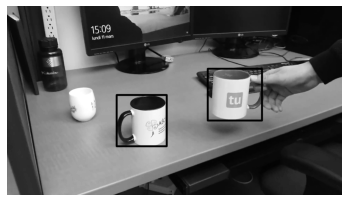

frame77.jpg
77 1 628 915 508 801

77 2 1150 1461 358 654



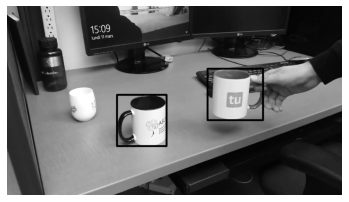

frame78.jpg
78 1 630 914 507 800

78 2 1149 1467 358 652



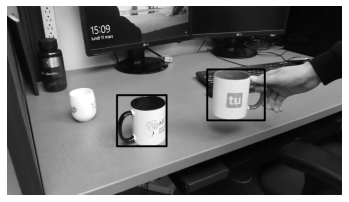

frame79.jpg
79 1 630 914 509 801

79 2 1147 1477 362 653



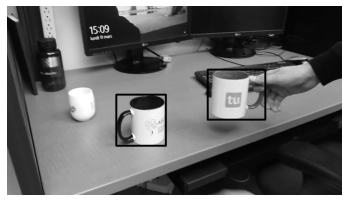

frame80.jpg
80 1 626 910 506 798

80 2 1150 1480 363 649



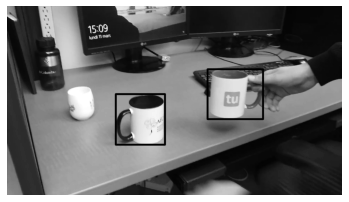

frame81.jpg
81 1 623 905 503 792

81 2 1149 1467 361 646



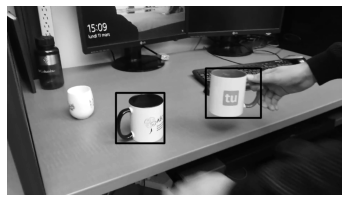

frame82.jpg
82 1 624 902 496 784

82 2 1139 1455 356 639



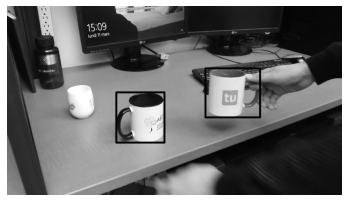

frame83.jpg
83 1 626 902 493 780

83 2 1137 1450 356 636



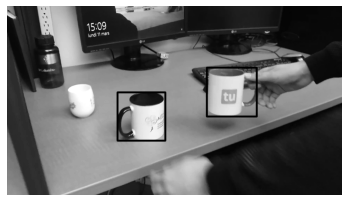

frame84.jpg
84 1 633 907 493 769

84 2 1145 1431 352 631



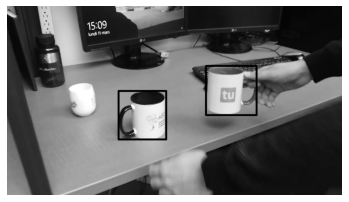

frame85.jpg
85 1 639 912 485 762

85 2 1140 1430 342 623



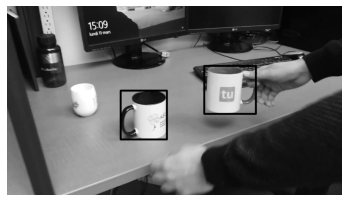

frame86.jpg
86 1 651 916 483 762

86 2 1130 1426 342 616



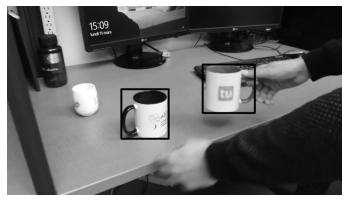

frame87.jpg
87 1 655 926 475 758

87 2 1121 1420 334 611



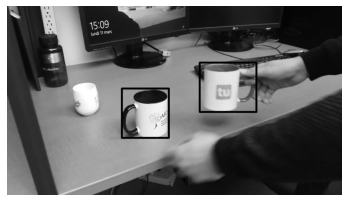

frame88.jpg
88 1 658 927 471 753

88 2 1104 1429 323 605



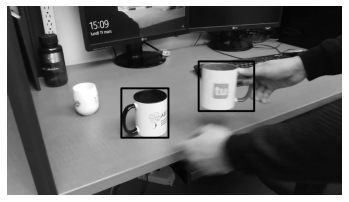

frame89.jpg
89 1 655 925 470 752

89 2 1098 1416 316 600



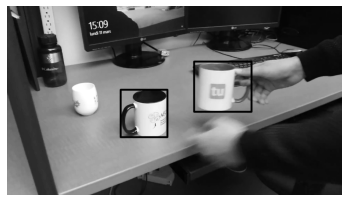

frame90.jpg
90 1 651 919 478 749

90 2 1072 1401 317 604



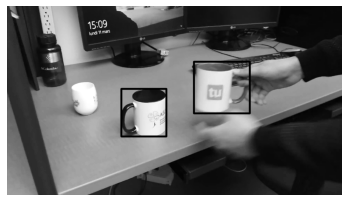

frame91.jpg
91 1 655 913 473 745

91 2 1071 1391 318 613



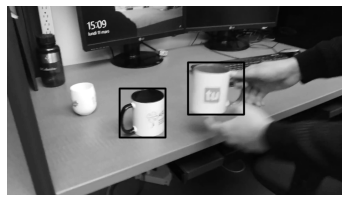

frame92.jpg
92 1 645 908 471 751

92 2 1037 1358 322 620



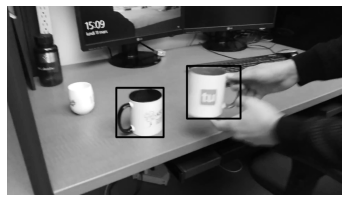

frame93.jpg
93 1 626 897 467 749

93 2 1031 1338 342 643



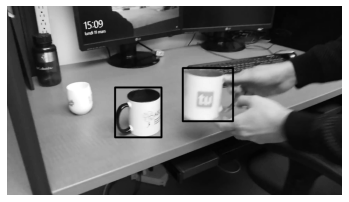

frame94.jpg
94 1 619 885 465 750

94 2 1007 1295 354 658



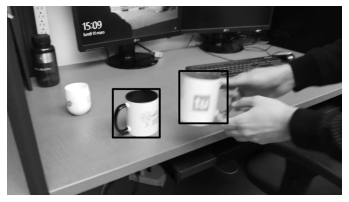

frame95.jpg
95 1 606 875 474 751

95 2 987 1264 371 670



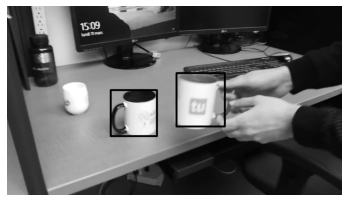

frame96.jpg
96 1 594 859 480 743

96 2 971 1248 383 688



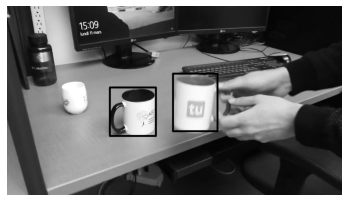

frame97.jpg
97 1 589 853 465 742

97 2 951 1206 386 715



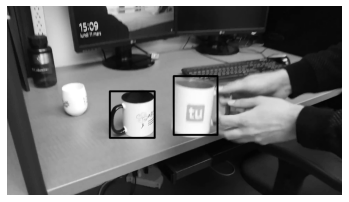

frame98.jpg
98 1 589 846 487 753

98 2 955 1206 400 736



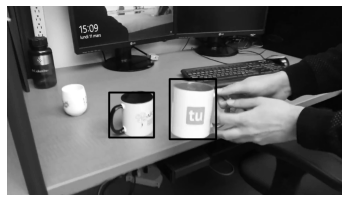

frame99.jpg
99 1 585 842 494 751

99 2 932 1198 417 761



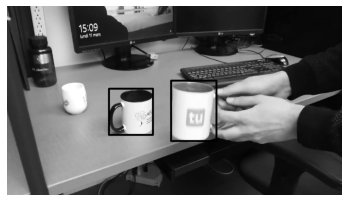

frame100.jpg
100 1 584 836 472 736

100 2 940 1200 426 771



In [80]:
### Validation des résultats

f = open("result_cups.txt", "r")
lines = f.readlines()
f.close()

frames = [name for name in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, name))]
frames = sorted(frames)
frames = sorted(frames, key = lambda s : len(s))

i = 51
for j in range (0, 50):
    img = cv2.imread(os.path.join(source_path, frames[i-1+j]), cv2.IMREAD_GRAYSCALE)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))+1].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis("off")
    plt.show()
    
    print(frames[i-1+j])
    print(lines[(2*(i-1+j))])
    print(lines[(2*(i-1+j))+1])
